## Requirements

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import joblib
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# CLUSTERING

In this notebook I will develop the clustering exercise. I want to segment the clients (CARD NUMBER). By doing this, I will find clusters that can be used later by the Birmingham Government to identify if there are Cards/People/Dictatorates with similar patterns

## Feature Engineering
For this analysis, one of the most important variables is the category of the purchase/transaction (TRANS CAC DESC 1) and Dictatorates. Because of this, I will compute the following variables:

*   Number of transactions per category
* Number of transactions per Dictatorate
*   Number of transactions
*   Sum of costs of transactions
*   Avg value per transactions
* Number of unique categories in which has done transactions

In [2]:
drive.mount('/content/drive/')
folder_path = '/content/drive/MyDrive/Globant/Data/'
df = pd.read_csv(folder_path+'clean_data.csv', sep ='|')[['CARD NUMBER', 'DIRECTORATE','TRANS CAC DESC 1',  'ORIGINAL GROSS AMT 1' ]]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df

,CARD NUMBER,DIRECTORATE,TRANS CAC DESC 1,ORIGINAL GROSS AMT 1
0,************6208,ADULT SOCIAL CARE,Vehicle Fuel,0.00
1,************6208,ADULT SOCIAL CARE,Vehicle Fuel,0.00
2,************6208,ADULT SOCIAL CARE,Vehicle Fuel,0.00
3,************8738,ADULT SOCIAL CARE,Vehicle Fuel,0.00
4,************8738,ADULT SOCIAL CARE,Vehicle Fuel,0.00
...,...,...,...,...
49192,************8087,SCHOOLS,other,59.99
49193,************4310,SCHOOLS,other,371.80
49194,************4310,SCHOOLS,other,147.98
49195,************4310,SCHOOLS,other,69.99


In [4]:
#I start creating the dataframe I'm going to use for my clusters
df['count'] = 1
df_clusters = df.groupby('CARD NUMBER').agg(Count_Transactions=('count',np.sum), Sum_Value_Transactions=('ORIGINAL GROSS AMT 1',np.sum),avg_Value_Transactions=('ORIGINAL GROSS AMT 1',np.mean),
                              Count_Unique_Categories=('TRANS CAC DESC 1',pd.Series.nunique))
df_clusters

,Count_Transactions,Sum_Value_Transactions,avg_Value_Transactions,Count_Unique_Categories
CARD NUMBER,,,,
************0031,1,99.58,99.580000,1
************0037,9,3342.11,371.345556,3
************0057,15,1556.99,103.799333,3
************0065,117,16771.67,143.347607,16
************0085,1,120.28,120.280000,1
...,...,...,...,...
************9961,35,3993.73,114.106571,3
************9979,161,13302.18,82.622236,5
************9987,27,1737.58,64.354815,3


In [5]:
# I create the dummy columns
dummy=['TRANS CAC DESC 1']
df_dummy = pd.get_dummies(df[['CARD NUMBER','TRANS CAC DESC 1']],columns=dummy,drop_first=True)
df_dummy

,CARD NUMBER,TRANS CAC DESC 1_Bldg RM Departmental,TRANS CAC DESC 1_Books,TRANS CAC DESC 1_Clothing&Uniforms,TRANS CAC DESC 1_Computing Other,TRANS CAC DESC 1_Conference Fees Subs UK,TRANS CAC DESC 1_Electricity,TRANS CAC DESC 1_Equip Operational,TRANS CAC DESC 1_Equip Other,TRANS CAC DESC 1_Hospitality,...,TRANS CAC DESC 1_Supplies & Sev Mic,TRANS CAC DESC 1_Training Other,TRANS CAC DESC 1_Transport Misc,TRANS CAC DESC 1_Travel Bus/Rail,TRANS CAC DESC 1_Travel Taxis,TRANS CAC DESC 1_Vehicle Excise Lics,TRANS CAC DESC 1_Vehicle Fuel,TRANS CAC DESC 1_Vehicle OthrunCosts,TRANS CAC DESC 1_Water Services,TRANS CAC DESC 1_other
0,************6208,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,************6208,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,************6208,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,************8738,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,************8738,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49192,************8087,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
49193,************4310,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
49194,************4310,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
49195,************4310,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [6]:
# I compute the number of transactions per directorate and per category
df_dummy = df_dummy.groupby('CARD NUMBER').sum().reset_index()
df_dummy

,CARD NUMBER,TRANS CAC DESC 1_Bldg RM Departmental,TRANS CAC DESC 1_Books,TRANS CAC DESC 1_Clothing&Uniforms,TRANS CAC DESC 1_Computing Other,TRANS CAC DESC 1_Conference Fees Subs UK,TRANS CAC DESC 1_Electricity,TRANS CAC DESC 1_Equip Operational,TRANS CAC DESC 1_Equip Other,TRANS CAC DESC 1_Hospitality,...,TRANS CAC DESC 1_Supplies & Sev Mic,TRANS CAC DESC 1_Training Other,TRANS CAC DESC 1_Transport Misc,TRANS CAC DESC 1_Travel Bus/Rail,TRANS CAC DESC 1_Travel Taxis,TRANS CAC DESC 1_Vehicle Excise Lics,TRANS CAC DESC 1_Vehicle Fuel,TRANS CAC DESC 1_Vehicle OthrunCosts,TRANS CAC DESC 1_Water Services,TRANS CAC DESC 1_other
0,************0031,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,************0037,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,6
2,************0057,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,4
3,************0065,0,1,0,2,0,0,14,0,0,...,0,1,1,1,4,0,0,0,0,43
4,************0085,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,************9961,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,22
729,************9979,0,0,0,0,0,0,3,16,0,...,0,0,0,0,0,0,0,0,0,68
730,************9987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,16,0,0,10
731,************9989,0,0,0,2,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,46


In [7]:
# I join both dataframes to get my final dataframe for clustering
df_clusters_interm = pd.merge(df_dummy, df_clusters, on='CARD NUMBER')

In [8]:
df_clusters_interm

,CARD NUMBER,TRANS CAC DESC 1_Bldg RM Departmental,TRANS CAC DESC 1_Books,TRANS CAC DESC 1_Clothing&Uniforms,TRANS CAC DESC 1_Computing Other,TRANS CAC DESC 1_Conference Fees Subs UK,TRANS CAC DESC 1_Electricity,TRANS CAC DESC 1_Equip Operational,TRANS CAC DESC 1_Equip Other,TRANS CAC DESC 1_Hospitality,...,TRANS CAC DESC 1_Travel Taxis,TRANS CAC DESC 1_Vehicle Excise Lics,TRANS CAC DESC 1_Vehicle Fuel,TRANS CAC DESC 1_Vehicle OthrunCosts,TRANS CAC DESC 1_Water Services,TRANS CAC DESC 1_other,Count_Transactions,Sum_Value_Transactions,avg_Value_Transactions,Count_Unique_Categories
0,************0031,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,99.58,99.580000,1
1,************0037,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,6,9,3342.11,371.345556,3
2,************0057,0,0,0,0,0,0,0,0,0,...,0,0,10,0,0,4,15,1556.99,103.799333,3
3,************0065,0,1,0,2,0,0,14,0,0,...,4,0,0,0,0,43,117,16771.67,143.347607,16
4,************0085,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,120.28,120.280000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,************9961,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,22,35,3993.73,114.106571,3
729,************9979,0,0,0,0,0,0,3,16,0,...,0,0,0,0,0,68,161,13302.18,82.622236,5
730,************9987,0,0,0,0,0,0,0,0,0,...,0,0,16,0,0,10,27,1737.58,64.354815,3
731,************9989,0,0,0,2,0,0,25,0,0,...,0,0,0,0,0,46,101,7395.16,73.219406,7


In [9]:
df_clusters_interm.columns

Index(['CARD NUMBER', 'TRANS CAC DESC 1_Bldg RM Departmental',
       'TRANS CAC DESC 1_Books', 'TRANS CAC DESC 1_Clothing&Uniforms',
       'TRANS CAC DESC 1_Computing Other',
       'TRANS CAC DESC 1_Conference Fees Subs UK',
       'TRANS CAC DESC 1_Electricity', 'TRANS CAC DESC 1_Equip Operational',
       'TRANS CAC DESC 1_Equip Other', 'TRANS CAC DESC 1_Hospitality',
       'TRANS CAC DESC 1_In Year Credits', 'TRANS CAC DESC 1_Mat'l Raw/Drct',
       'TRANS CAC DESC 1_Oth Indirect EmpExps',
       'TRANS CAC DESC 1_Other Fix&Fittings',
       'TRANS CAC DESC 1_Other Services',
       'TRANS CAC DESC 1_Phon NonCentrx Lines', 'TRANS CAC DESC 1_Postage',
       'TRANS CAC DESC 1_Prof Fees other', 'TRANS CAC DESC 1_Purchases Food',
       'TRANS CAC DESC 1_Stationery', 'TRANS CAC DESC 1_Subscriptions',
       'TRANS CAC DESC 1_Supplies & Sev Mic',
       'TRANS CAC DESC 1_Training Other', 'TRANS CAC DESC 1_Transport Misc',
       'TRANS CAC DESC 1_Travel Bus/Rail', 'TRANS CAC DESC 1_

## Standarize
In order to make the clustering process more efficient, I standarize the columns

In [10]:
stnd_scl = StandardScaler()
columns_n = ['TRANS CAC DESC 1_Bldg RM Departmental',
       'TRANS CAC DESC 1_Books', 'TRANS CAC DESC 1_Clothing&Uniforms',
       'TRANS CAC DESC 1_Computing Other',
       'TRANS CAC DESC 1_Conference Fees Subs UK',
       'TRANS CAC DESC 1_Electricity', 'TRANS CAC DESC 1_Equip Operational',
       'TRANS CAC DESC 1_Equip Other', 'TRANS CAC DESC 1_Hospitality',
       'TRANS CAC DESC 1_In Year Credits', "TRANS CAC DESC 1_Mat'l Raw/Drct",
       'TRANS CAC DESC 1_Oth Indirect EmpExps',
       'TRANS CAC DESC 1_Other Fix&Fittings',
       'TRANS CAC DESC 1_Other Services',
       'TRANS CAC DESC 1_Phon NonCentrx Lines', 'TRANS CAC DESC 1_Postage',
       'TRANS CAC DESC 1_Prof Fees other', 'TRANS CAC DESC 1_Purchases Food',
       'TRANS CAC DESC 1_Stationery', 'TRANS CAC DESC 1_Subscriptions',
       'TRANS CAC DESC 1_Supplies & Sev Mic',
       'TRANS CAC DESC 1_Training Other', 'TRANS CAC DESC 1_Transport Misc',
       'TRANS CAC DESC 1_Travel Bus/Rail', 'TRANS CAC DESC 1_Travel Taxis',
       'TRANS CAC DESC 1_Vehicle Excise Lics', 'TRANS CAC DESC 1_Vehicle Fuel',
       'TRANS CAC DESC 1_Vehicle OthrunCosts',
       'TRANS CAC DESC 1_Water Services', 'TRANS CAC DESC 1_other',
       'Count_Transactions', 'Sum_Value_Transactions',
       'avg_Value_Transactions', 'Count_Unique_Categories']
df_clusters_final = df_clusters_interm.copy()
df_clusters_final[columns_n] = stnd_scl.fit_transform(df_clusters_final[columns_n])

# Clustering
I will use DBSCAN clustering technique. The cluster will be selected by the density of datapoints.
In this type of clustering there are two parameters to determine:


*   Epsilon: the maximum distance two points can be from one another while still belonging to the same cluster. This is determined by the point of max curvature in the K-distance graph.
*   minPoints: The general rule is numberOfFeatures * 2



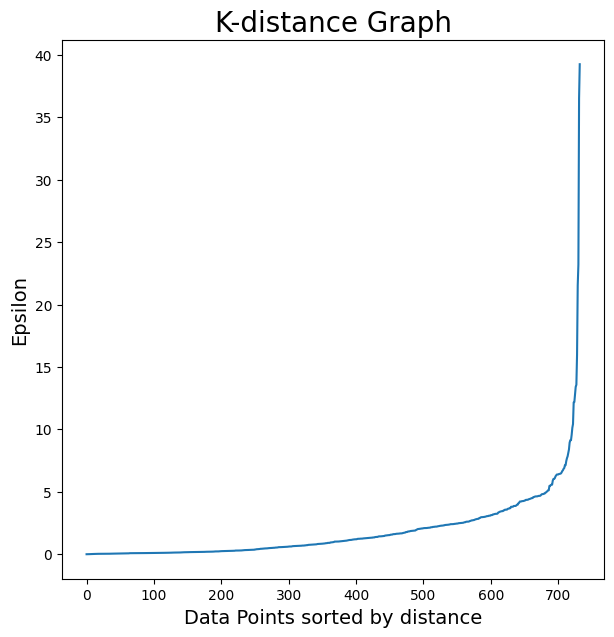

In [11]:
KNN = NearestNeighbors(n_neighbors=3)
KNN_ = KNN.fit(df_clusters_final[columns_n])
distances, indices = KNN_.kneighbors(df_clusters_final[columns_n])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(7,7))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [12]:
dbscan = DBSCAN(eps=5,min_samples=len(columns_n))
dbscan.fit(df_clusters_final[columns_n])

DBSCAN(eps=5, min_samples=34)

In [13]:
df_clusters_final['DBSCAN_labels']=dbscan.labels_

In [14]:
df_clusters_final['DBSCAN_labels'].unique()

array([ 0, -1])

In [15]:
joblib.dump(dbscan, '/content/drive/MyDrive/Globant/Models/cluster.pkl')

['/content/drive/MyDrive/Globant/Models/cluster.pkl']

In [16]:
joblib.dump(stnd_scl, '/content/drive/MyDrive/Globant/Models/scaler_cluster.pkl')

['/content/drive/MyDrive/Globant/Models/scaler_cluster.pkl']

## Plots
I plotted the cluster in two different ways. The first one uses t-Distributed Stochastic Neighbor Embedding (t-SNE) which takes all the dimensions of the dataset and reduces them to 2 dimension so it can be plotted.
https://medium.com/@tarammullin/visualizing-dbscan-results-with-t-sne-plotly-e3742205c900

 Because the difference in the clusters wasn't evident, I also did  pairplots that compares some columns of the dataframe and shows how the clustering method segmented the data points. With the last graph, we can evidence the distinctions between both clusters

 https://www.kaggle.com/code/rohanadagouda/unsupervised-learning-using-k-prototype-and-dbscan

In [18]:
X_embedded = TSNE(n_components=2).fit_transform(df_clusters_final[columns_n])
df_clusters_final["x_component"]=X_embedded[:,0]
df_clusters_final["y_component"]=X_embedded[:,1]
fig = px.scatter(df_clusters_final, x="x_component", y="y_component", color = "DBSCAN_labels", size_max=30)
fig.update_layout(height=600)
fig.show()

<ipython-input-19-f94783afe8f8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster_id
 0    644
-1     89
Name: count, dtype: int64


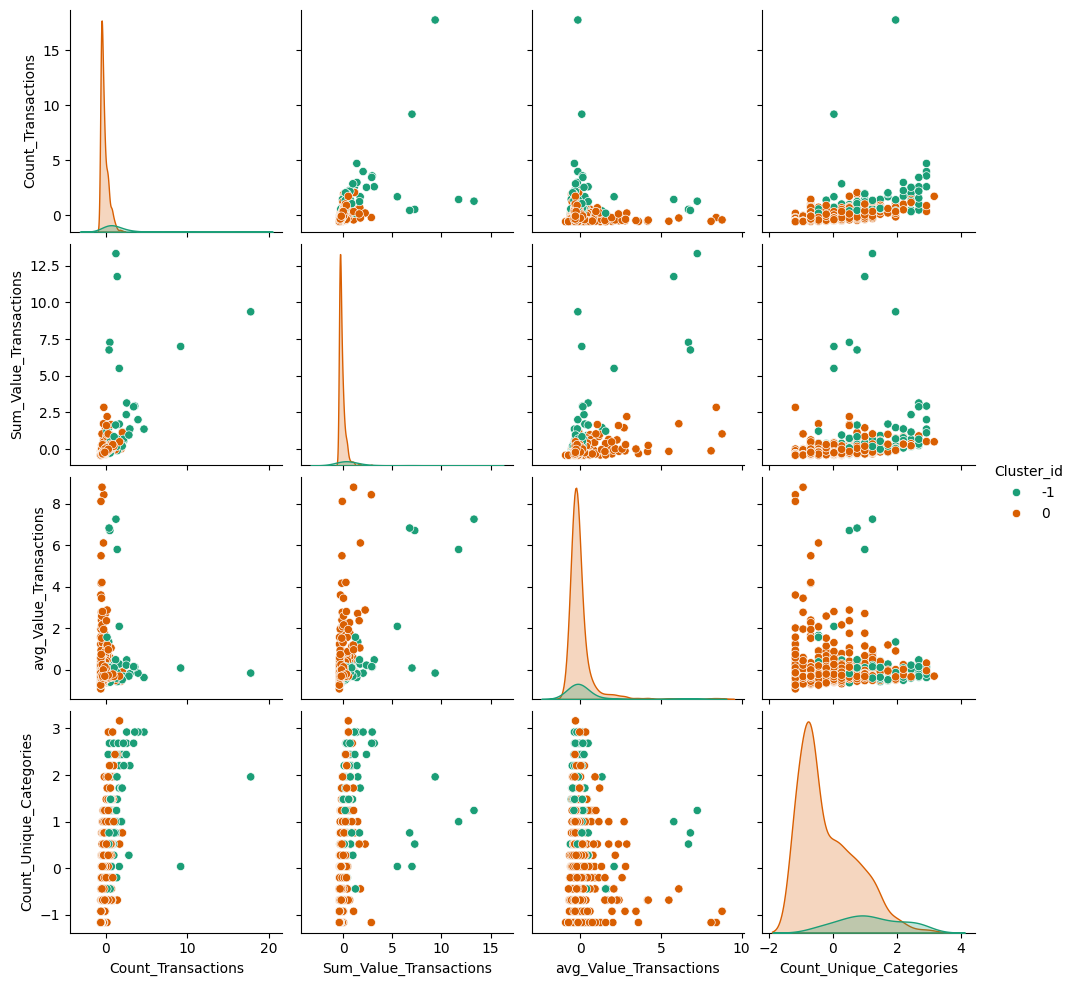

In [19]:
a = df_clusters_final[[
       'Count_Transactions', 'Sum_Value_Transactions',
       'avg_Value_Transactions', 'Count_Unique_Categories']]
a['Cluster_id']=dbscan.labels_
print(a['Cluster_id'].value_counts())
sns.pairplot(a,hue='Cluster_id',palette='Dark2',diag_kind='kde')

In [ ]:
df['count'] = 1
summary = df.groupby('CARD NUMBER').agg(Count_Transactions=('count',np.sum), Sum_Value_Transactions=('ORIGINAL GROSS AMT 1',np.sum),avg_Value_Transactions=('ORIGINAL GROSS AMT 1',np.mean),
                              Count_Unique_Categories=('TRANS CAC DESC 1',pd.Series.nunique))
df_clusters

In [21]:
summary = pd.merge(df,df_clusters_final[['CARD NUMBER', 'DBSCAN_labels']], on = 'CARD NUMBER', how = 'inner')
summary['count'] = 1
summary.groupby('DBSCAN_labels').agg(Count_Transactions=('count',np.sum), Sum_Value_Transactions=('ORIGINAL GROSS AMT 1',np.sum),avg_Value_Transactions=('ORIGINAL GROSS AMT 1',np.mean),
                              Count_Unique_Categories=('TRANS CAC DESC 1',pd.Series.nunique), Categories=('TRANS CAC DESC 1',pd.Series.mode), DIRECTORATE=('DIRECTORATE',pd.Series.mode))

,Count_Transactions,Sum_Value_Transactions,avg_Value_Transactions,Count_Unique_Categories,Categories,DIRECTORATE
DBSCAN_labels,,,,,,
-1,18317,2503312.22,136.666060,31,other,SCHOOLS
0,30880,3027962.91,98.055794,31,other,SCHOOLS


# Conclusion
Both clusters mainly differenciate because:


*   Clients/People from Cluster -1 have less transactions than cluster 0
*   Clients/People from Cluster -1 spent less (in total) than cluster 0
*   Clients/People from Cluster -1 spent more per transaction than cluster 0

In conclusion, cluster -1 don't make transactions so often but spent more

